# Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


### Load data ###

In [35]:
base_dir = 'data'
img_size = (224, 224)
batch_size = 32
epochs = 30

### Augmentation ###

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 1500 images belonging to 4 classes.
Found 300 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


### Load MobileNetV2 ###

In [28]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

### Custom Head

In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

### Compile

In [30]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Callback

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

### Train

In [32]:
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\asus\anaconda3\envs\main-ds\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.2990 - loss: 1.6412 - val_accuracy: 0.6467 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Epoch 2/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.4603 - loss: 1.2018 - val_accuracy: 0.7500 - val_loss: 0.8482 - learning_rate: 1.0000e-04
Epoch 3/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5905 - loss: 1.0219 - val_accuracy: 0.7600 - val_loss: 0.7444 - learning_rate: 1.0000e-04
Epoch 4/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6620 - loss: 0.8904 - val_accuracy: 0.7733 - val_loss: 0.6732 - learning_rate: 1.0000e-04
Epoch 5/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6537 - loss: 0.8462 - val_accuracy: 0.7733 - val_loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 6/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.6869 - loss: 0.7882 - val_accuracy: 0.7800 - val_loss: 0.5983 - learning_rate: 1.0000e-04
Epoch 7/35
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7153 - loss:

### Plotting

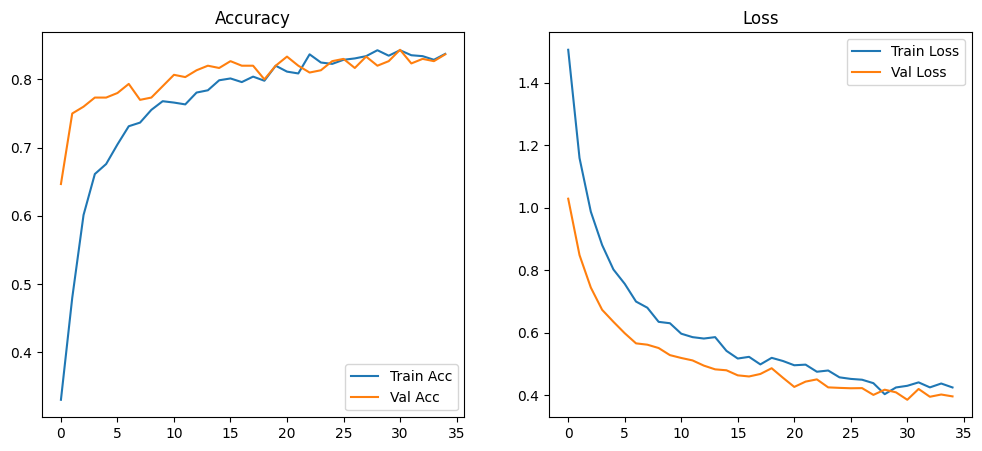

In [33]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

### Evaluation

In [34]:
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))

200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.96      0.88        50
meningioma_tumor       0.86      0.64      0.74        50
        no_tumor       0.98      0.88      0.93        50
 pituitary_tumor       0.81      0.96      0.88        50

        accuracy                           0.86       200
       macro avg       0.87      0.86      0.86       200
    weighted avg       0.87      0.86      0.86       200



In [1]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Label sebenarnya dari data testing
y_true = test_generator.classes

# Nama label (pastikan sesuai dengan urutan class_indices)
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi menggunakan seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNetV2')
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined